In [ ]:
from utils import zdataset, show, labwidget, renormalize
from rewrite import ganrewrite, rewriteapp
import torch, copy, os, json
from torchvision.utils import save_image
from torchvision import transforms
import utils.stylegan2, utils.proggan
from utils.stylegan2 import load_seq_stylegan

import numpy as np
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm, trange
import cv2

from utils import unet, anomaly

from pytorch_msssim import ssim, ms_ssim
from skimage.measure import compare_ssim
#from skimage.metrics import structural_similarity as ssim

In [ ]:
def dilate(mask,kernel_size=(8,8)):
    kernel = np.ones(kernel_size, np.uint8)
    mask = cv2.dilate(mask, kernel)
    return mask

def segment(seg_model, images, ch=3, size=(224,224), threshold=0.5):
    trans = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                              ])
    images_tensor = torch.empty((len(images), ch, size[0], size[1]))
    for i in range(len(images)):
        images_tensor[i] = trans(images[i])
        
    seg_masks = seg_model(images_tensor.cuda()).sigmoid().detach().cpu()
    seg_masks = torch.where(seg_masks > threshold, torch.ones(seg_masks.size()), torch.zeros(seg_masks.size()))
    return seg_masks

def masks_to_colorimg(masks):
    colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132), (160, 194, 56), (155, 89, 182)])

    colorimg = np.ones((masks.shape[1], masks.shape[2], 3), dtype=np.float32) * 255
    channels, height, width = masks.shape

    for y in range(height):
        for x in range(width):
            selected_colors = colors[masks[:,y,x] > 0.5]

            if len(selected_colors) > 0:
                colorimg[y,x,:] = np.mean(selected_colors, axis=0)

    return colorimg.astype(np.uint8)



def find_best_seg_match(mask, seg_mask, channels=None):
    scores = []
    if channels is None:
        channels = list(range(seg_mask.shape[0]))
    for i in range(seg_mask.shape[0]):
        if i not in channels:
            scores.append(-1)
            continue
        
        iou_score = jaccard_score(mask.reshape(-1), seg_mask[i].reshape(-1))
        scores.append(iou_score)
    best_ch = np.argmax(scores)
    return best_ch

def render_mask(tup, gw, size=512):
    imgnum, mask = tup
    area = (renormalize.from_url(mask, target='pt', size=(size,size))[0] > 0.25)
    return gw.render_image(imgnum, mask=area)

def show_masks(masks, gw):
    n = len(masks)
    if n == 1:
        masks = masks[0]
    if type(masks) is tuple:
        plt.imshow(render_mask(masks, gw))
        return

    fig, axes = plt.subplots(1, n, figsize=(n*3, 3))
    for i in range(n):
        axes[i].imshow(render_mask(masks[i], gw))

In [39]:
model_path = "./models/stylegan2_bike.pt"
model_size = 512
truncation = 0.5

name='bike1k'

seg_model_path = './models/segmentation_bike.pt'

data_path = '/home/gridsan/ahnobari/rashad/anomaly_dataset/bike1k/train/good'
k=50,
anomaly_threshold = 3.5

# Copy id for frame example shown in overleaf paper
# 907, 728, 348, 960

# Copy id for handle example shown in overleaf paper
# 580, 811, 576

copy_id=907
paste_id=7
key_ids=list(range(7,7+5))
gen_dir = 'gen_examples/ex7'

seg_class = 7
channels=[0, 3]
# 0 - frame
# 1 - saddle
# 2 - wheel
# 3 - handle
# eg. [0, 3] - only frame or handle will be used for rewriting

layer=8
rank=30
lr=0.05
niter=2000

use_copy_as_paste_mask = False
dilate_mask= True
dilate_kernel_size=(16,16)

load train set feature from: ./anomaly_cache/temp/train_bike1k.pkl


| feature extraction |: 100%|██████████| 1/1 [00:00<00:00, 92.80it/s]
| localization | test|:   0%|          | 0/1 [00:00<?, ?it/s]

unet loaded


| localization | test|: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


/home/gridsan/ahnobari/.conda/envs/renv2/lib/python3.6/site-packages/ipykernel_launcher.py:183: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


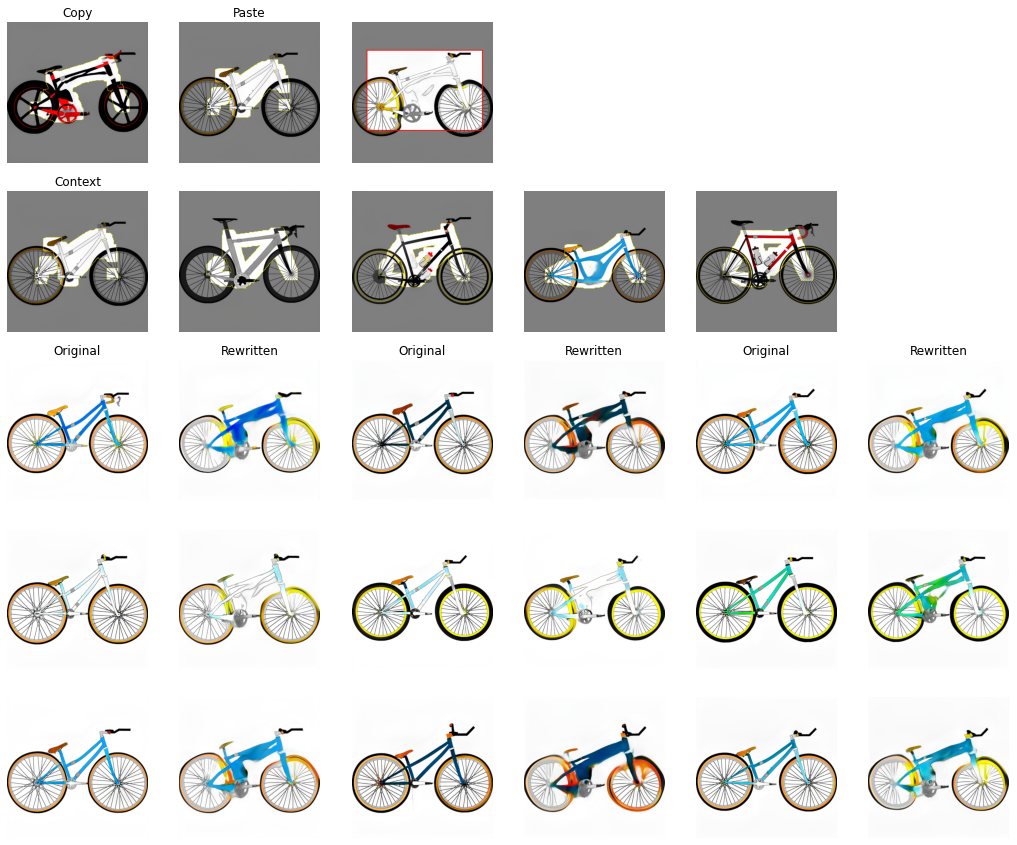

In [40]:

# Choices: ganname = 'stylegan' or ganname = 'proggan'
ganname = 'stylegan'

modelname = 'bike'

layernum = layer

# Number of images to sample when gathering statistics.
size = 10000

# Make a directory for caching some data.
layerscheme = 'default'
expdir = 'results/pgw/%s/%s/%s/layer%d' % (ganname, modelname, layerscheme, layernum)
os.makedirs(expdir, exist_ok=True)

# Load (and download) a pretrained GAN
if ganname == 'stylegan':
    model = load_seq_stylegan(model_path, path=True, size=model_size, mconv='seq', truncation=truncation)
    Rewriter = ganrewrite.SeqStyleGanRewriter
elif ganname == 'proggan':
    model = utils.proggan.load_pretrained(modelname)
    Rewriter = ganrewrite.ProgressiveGanRewriter
    
# Create a Rewriter object - this implements our method.
zds = zdataset.z_dataset_for_model(model, size=size)
gw = Rewriter(
    model, zds, layernum, cachedir=expdir,
    low_rank_insert=True, low_rank_gradient=False,
    use_linear_insert=False,  # If you set this to True, increase learning rate.e
    key_method='zca')

# Display a user interface to allow model rewriting.
savedir = f'masks/{ganname}/{modelname}'
interface = rewriteapp.GanRewriteApp(gw, size=256, mask_dir=savedir, num_canvases=32)

# Create detector instance given a directory of the normal images
ad = anomaly.AnomalyDetector(data_path, name='bike1k', topk=50)

# Extract and cache embeddings of the normal images
ad.load_train_features()

# anomaly_scores = []
# for i in range(0, 1000, 100):
#     images = gw.render_image_batch(list(range(i,i+100)))
#     scores = ad.predict_anomaly_scores(images)
#     anomaly_scores.append(scores)

# anomaly_scores = np.concatenate(anomaly_scores)
# top_idx = anomaly_scores.argsort()[::-1]


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


num_class = 7
seg_model = unet.ResNetUNet(7).cuda()

seg_model.load_state_dict(torch.load(seg_model_path))
seg_model.eval()

print('unet loaded')

# Copy Mask
image = gw.render_image(copy_id)
copy_anomaly = ad.predict_anomaly_masks([image])
copy_mask = ad.threshold_masks(copy_anomaly, threshold=anomaly_threshold)[0]
seg_mask = segment(seg_model, [image])[0]

best_ch = find_best_seg_match(copy_mask, seg_mask.numpy(), channels=channels)
mask = seg_mask[best_ch].numpy()
if dilate_mask:
    mask = dilate(mask, kernel_size=dilate_kernel_size)
mask = Image.fromarray(mask.astype('uint8')*255, mode='L')
area = (renormalize.from_image(mask, target='pt', size=(512,512))[0] > 0.25)
mask_url = renormalize.as_url(mask)
obj_acts, obj_output, obj_area, bounds = (gw.object_from_selection(copy_id, mask_url))
interface.request['object'] = (copy_id, mask_url)


# Paste Mask
image = gw.render_image(paste_id)
seg_mask = segment(seg_model, [image])[0]
if not use_copy_as_paste_mask:
    mask = seg_mask[best_ch].numpy()
    if dilate_mask:
        mask = dilate(mask, kernel_size=dilate_kernel_size)
    mask = Image.fromarray(mask.astype('uint8')*255, mode='L')
area = (renormalize.from_image(mask, target='pt', size=(512,512))[0] > 0.25)
mask_url = renormalize.as_url(mask)
interface.request['paste'] = (paste_id, mask_url)

# Render Paste Image
goal_in, goal_out, viz_out, bounds = gw.paste_from_selection(paste_id, mask_url, obj_acts, obj_area)
imgout = renormalize.as_url(gw.render_object(viz_out, box=bounds))
render_image = gw.render_object(viz_out, box=bounds)

#Context Mask
# key_ids = top_idx[-50:-1:10]
images = gw.render_image_batch(key_ids)
seg_masks = segment(seg_model, images)

best_seg_masks = seg_masks.permute(1,0,2,3)[best_ch]
interface.request['key'] = []
for i, idx in enumerate(key_ids):
    mask = best_seg_masks[i].numpy()
    if dilate_mask:
        mask = dilate(mask, kernel_size=dilate_kernel_size)
    mask = Image.fromarray(mask.astype('uint8')*255, mode='L')
    area = (renormalize.from_image(mask, target='pt', size=(512,512))[0] > 0.25)
    mask_url = renormalize.as_url(mask)
    interface.request['key'].append((idx, mask_url))

# Rewriting
def update_callback(it, loss):
    if it % 50 == 0 or it == niter - 1:
        loss_info = (f'lr {lr:.4f}\titer {it: 6d}/{niter: 6d}'
                     f'\tloss {loss.item():.4f}')
        print(loss_info, end='\r')
                
gw.apply_edit(interface.request,
                           rank=rank, niter=niter, piter=10, lr=lr,
                           update_callback=update_callback)


imgnum, mask = interface.request['key'][0]
key = gw.query_key_from_selection(imgnum, mask)
sel, rq = gw.ranking_for_key(key, k=200)
img_nums = sel.tolist()


saved_state_dict = copy.deepcopy(gw.model.state_dict())

with torch.no_grad():
    gw.model.load_state_dict(saved_state_dict)
    edited_images = gw.render_image_batch(img_nums)
#     for i in range(10):
#         imgs = gw.render_image_batch(list(range(i*100,i*100+100)))
#         for j, im in enumerate(imgs):
#             im.resize((224,224)).save(os.path.join(gen_dir, f'{i*100+j}.png'))
    gw.model.load_state_dict(interface.original_model.state_dict())
    images = gw.render_image_batch(img_nums)

    
# Visualize Result
offset = 2
n = 9
n_col = 3

mask_savedir = "rewriting_masks"
result_savedir = "rewriting_results"

row = n//n_col
col = n_col * 2
fig, axes = plt.subplots(offset + row, col, figsize=(col*3, (offset+row)*3))

for ax in axes.ravel():
    ax.axis('off')

req = interface.request

obj = render_mask(req['object'], gw)
paste = render_mask(req['paste'], gw)
axes[0, 0].imshow(obj)
axes[0, 0].title.set_text('Copy')
axes[0, 1].imshow(paste)
axes[0, 1].title.set_text('Paste')
axes[0, 2].imshow(render_image)

axes[1, 0].title.set_text('Context')
for i in range(min(n, len(req['key']))):
    context = render_mask(req['key'][i], gw)
    axes[1, i].imshow(context)


for c in range(n_col):
    axes[offset, c*2].title.set_text('Original')
    axes[offset, c*2+1].title.set_text('Rewritten')

for i in range(n):
    axes[offset+i%row, i//row*2].imshow(images[i])
    axes[offset+i%row, i//row*2 + 1].imshow(edited_images[i])
    
fig.show()

# Save Result
os.makedirs(mask_savedir, exist_ok=True)
os.makedirs(result_savedir, exist_ok=True)

overwrite = False
ver = 0
name = f"{modelname}_c{copy_id}_p{paste_id}_layer{layernum}_rank{rank}_exp"

while os.path.exists(os.path.join(result_savedir, name+str(ver)+'.png')) and not overwrite:
    ver += 1
name = name + str(ver)
fig.savefig(os.path.join(result_savedir, name), bbox_inches='tight')
data = interface.request
data['sel'] = img_nums

def convert(o):
    if isinstance(o, np.int64): return int(o)  
    raise TypeError

with open(os.path.join(mask_savedir, '%s.json' % name), 'w') as f:
    json.dump(data, f, indent=1, default=convert)
    
 

In [155]:
from torch.utils.data import DataLoader

batch_size = 1
gen_dataset1 = anomaly.NormalDataset('genbike10', grayscale=False, normalize=False, resize=512, cropsize=512)
gen_dataset2 = anomaly.NormalDataset('genbike10', grayscale=False, normalize=False, resize=512, cropsize=512)
gen_loader1 = DataLoader(gen_dataset1, batch_size=1, pin_memory=True)
gen_loader2 = DataLoader(gen_dataset2, batch_size=batch_size, pin_memory=True)
n = len(gen_dataset1)
ssim_mat = torch.zeros((n, n))
with tqdm(total=n * n) as pbar:
    for i, x in enumerate(gen_loader1):
        x = x.repeat(batch_size, 1, 1, 1)
        for j, y in enumerate(gen_loader2):
            #print(y.reshape(-1).max())
            #ssim_mat[i][j*batch_size:j*batch_size+len(y)] = ssim( x.cuda(), y.cuda(), data_range=1, size_average=False)
            #print(i,j)
            ssim_mat[i][j] = ssim( x.cuda(), y.cuda(), data_range=1, size_average=False)
            pbar.update(len(y))
ssim_mat = ssim_mat * (1 - torch.eye(n,n))
print('Mean: ', ssim_mat.mean())
print('Det: ', np.linalg.det(ssim_mat))

100%|██████████| 100/100 [00:00<00:00, 115.77it/s]

Mean:  tensor(0.5611)
Det:  -0.07726944


In [113]:
x = next(iter(gen_loader2))

In [128]:
from torch.utils.data import DataLoader

ssim_mats = []
n=100
m=4510
with tqdm(total=n * m * 8) as pbar:
    for ex in range(0,8):
        if ex == 0:
            print('Orginal')
            gen_dir = 'genbike1k'
        else:
            print(f'Ex{ex}')
            gen_dir = f'gen_examples/ex{ex}'
        # SSIM NOVELTY

        batch_size = 500
        gen_dataset1 = anomaly.NormalDataset(gen_dir, n=100, grayscale=False, normalize=False, resize=224, cropsize=224)
        gen_dataset2 = anomaly.NormalDataset('bike_dataset', grayscale=False, normalize=False, resize=224, cropsize=224)
        gen_loader1 = DataLoader(gen_dataset1, batch_size=1, pin_memory=True)
        gen_loader2 = DataLoader(gen_dataset2, batch_size=batch_size, pin_memory=True)
        n = len(gen_dataset1)
        m = len(gen_dataset2)
        ssim_mat = torch.zeros((n, m))
    
        for i, xb in enumerate(gen_loader1):
            x = xb.repeat(batch_size, 1, 1, 1)
            for j, y in enumerate(gen_loader2):
                if len(y) < batch_size:
                    x = xb.repeat(len(y), 1, 1, 1)
                ssim_mat[i][j*batch_size:j*batch_size+len(y)] = (1 - ssim(x.cuda(), y.cuda(), data_range=1, size_average=False))/2
                # ssim_mat[i][j*batch_size:j*batch_size+len(y)] = (1 + ssim(x.cuda(), y.cuda(), data_range=1, size_average=False))/2
                pbar.update(len(y))

        print('SSIM Mean: ', ssim_mat.mean().numpy())
        print('SSIM Top 1 Mean: ', torch.topk(ssim_mat, k=1).values.mean().numpy())
        print('SSIM Top 5 Mean: ', torch.topk(ssim_mat, k=5).values.mean().numpy())
        print('SSIM Top 10 Mean: ', torch.topk(ssim_mat, k=10).values.mean().numpy())
        print('SSIM Top 20 Mean: ', torch.topk(ssim_mat, k=20).values.mean().numpy())
        print('SSIM Top 50 Mean: ', torch.topk(ssim_mat, k=50).values.mean().numpy())
        ssim_mats.append(ssim_mat)
    
#     # SSIM DIVERSITY
#     batch_size = 100
#     gen_dataset1 = anomaly.NormalDataset(gen_dir, grayscale=False, normalize=False, resize=224, cropsize=224)
#     gen_loader1 = DataLoader(gen_dataset1, batch_size=batch_size, pin_memory=True)
#     #n = len(gen_dataset1)
#     n = len(gen_dataset1)//batch_size
#     ssim_mat = torch.zeros((batch_size, batch_size))
#     ssim_dets = []
#     with tqdm(total= n*batch_size*batch_size) as pbar:
#         for i, xb in enumerate(gen_loader1):
#             for j, x in enumerate(xb):
#                 x = x.repeat(batch_size, 1, 1, 1)
#                 #print(y.reshape(-1).max())
#                 #ssim_mat[i][j*batch_size:j*batch_size+len(y)] = ssim( x.cuda(), y.cuda(), data_range=1, size_average=False)
#                 #print(i,j)
#                 ssim_mat[j] = ssim( x.cuda(), xb.cuda(), data_range=1, size_average=False)
#                 pbar.update(len(xb))
#             ssim_mat = ssim_mat * (1 - torch.eye(batch_size,batch_size))
#             #ssim_det = np.linalg.det(ssim_mat)
#             ssim_det = np.mean(np.log(np.maximum(np.linalg.eigh(ssim_mat)[0],1e-7)))
#             ssim_dets.append(ssim_det)
#     print('Diversity Mean: ', np.mean(ssim_dets))
#     print('Diversity Std: ', np.std(ssim_dets))

for k in [0, 1,5,10,20,25,50]:
    topks = []
    for mat in ssim_mats:
        if k = 0:
            topk = ssim_mat.mean().numpy().item()
        else:
            topk = torch.topk(mat, k=k).values.mean().numpy().item()
        topks.append(topk)
    print(f'Top {k}')
    print(topks)
        

  0%|          | 0/3608000 [00:00<?, ?it/s]

Orginal


 12%|█▏        | 450990/3608000 [13:53<1:44:18, 504.46it/s]

SSIM Mean:  0.22275412
SSIM Top 1 Mean:  0.38558698
SSIM Top 5 Mean:  0.35585696
SSIM Top 10 Mean:  0.33861318
SSIM Top 20 Mean:  0.31402496
SSIM Top 50 Mean:  0.28818238
Ex1


 25%|██▍       | 901990/3608000 [27:28<1:22:42, 545.25it/s]

SSIM Mean:  0.22116108
SSIM Top 1 Mean:  0.38496873
SSIM Top 5 Mean:  0.35445625
SSIM Top 10 Mean:  0.33686337
SSIM Top 20 Mean:  0.31226143
SSIM Top 50 Mean:  0.28643405
Ex2


 37%|███▋      | 1352990/3608000 [41:06<1:02:02, 605.83it/s]

SSIM Mean:  0.22136228
SSIM Top 1 Mean:  0.38485566
SSIM Top 5 Mean:  0.35426733
SSIM Top 10 Mean:  0.33667934
SSIM Top 20 Mean:  0.3120699
SSIM Top 50 Mean:  0.2862058
Ex3


 50%|████▉     | 1803990/3608000 [54:43<54:30, 551.63it/s]  

SSIM Mean:  0.22183567
SSIM Top 1 Mean:  0.3850204
SSIM Top 5 Mean:  0.3546598
SSIM Top 10 Mean:  0.337225
SSIM Top 20 Mean:  0.31266105
SSIM Top 50 Mean:  0.2867697
Ex4


 62%|██████▏   | 2254990/3608000 [1:08:13<43:38, 516.70it/s]  

SSIM Mean:  0.2211375
SSIM Top 1 Mean:  0.38489974
SSIM Top 5 Mean:  0.3547434
SSIM Top 10 Mean:  0.3372524
SSIM Top 20 Mean:  0.31258672
SSIM Top 50 Mean:  0.28675896
Ex5


 75%|███████▍  | 2705990/3608000 [1:21:36<28:31, 526.88it/s]

SSIM Mean:  0.22151946
SSIM Top 1 Mean:  0.3851326
SSIM Top 5 Mean:  0.35469234
SSIM Top 10 Mean:  0.33730915
SSIM Top 20 Mean:  0.31263438
SSIM Top 50 Mean:  0.28682357
Ex6


 87%|████████▋ | 3156990/3608000 [1:35:48<13:51, 542.55it/s]

SSIM Mean:  0.22110917
SSIM Top 1 Mean:  0.38504288
SSIM Top 5 Mean:  0.35450685
SSIM Top 10 Mean:  0.33676678
SSIM Top 20 Mean:  0.31212625
SSIM Top 50 Mean:  0.2863494
Ex7


100%|██████████| 3608000/3608000 [1:50:01<00:00, 546.51it/s]

SSIM Mean:  0.22148794
SSIM Top 1 Mean:  0.38511413
SSIM Top 5 Mean:  0.35463208
SSIM Top 10 Mean:  0.33712122
SSIM Top 20 Mean:  0.31246626
SSIM Top 50 Mean:  0.28659773
Top 1
[0.3855869770050049, 0.38496872782707214, 0.3848556578159332, 0.3850204050540924, 0.38489973545074463, 0.3851326107978821, 0.38504287600517273, 0.3851141333580017]
Top 5
[0.3558569550514221, 0.35445624589920044, 0.35426732897758484, 0.3546597957611084, 0.3547433912754059, 0.35469233989715576, 0.35450685024261475, 0.35463207960128784]
Top 10
[0.3386131823062897, 0.33686336874961853, 0.3366793394088745, 0.3372249901294708, 0.3372524082660675, 0.3373091518878937, 0.33676677942276, 0.33712121844291687]
Top 20
[0.314024955034256, 0.3122614324092865, 0.3120698928833008, 0.3126610517501831, 0.3125867247581482, 0.3126343786716461, 0.3121262490749359, 0.31246626377105713]
Top 25
[0.30678442120552063, 0.30500468611717224, 0.30479511618614197, 0.3053920269012451, 0.3053215444087982, 0.3054090738296509, 0.30488720536231995,

In [150]:
for k in [0, 1,5,10,20,25,50]:
    topks = []
    for mat in ssim_mats:
        if k == 0:
            topk = mat.mean().numpy().item()
        else:
            topk = torch.topk(mat, k=k, largest=False).values.mean().numpy().item()
        topks.append(topk)
    print(f'topk[{k}] = {topks}')

topk[0] = [0.2227541208267212, 0.22116108238697052, 0.22136227786540985, 0.2218356728553772, 0.22113749384880066, 0.22151945531368256, 0.22110916674137115, 0.22148793935775757]
topk[1] = [0.14057797193527222, 0.1411922723054886, 0.1428700089454651, 0.14414602518081665, 0.14195096492767334, 0.14113491773605347, 0.1392800211906433, 0.14145860075950623]
topk[5] = [0.14670582115650177, 0.14732018113136292, 0.1482025682926178, 0.15024186670780182, 0.14800532162189484, 0.14744552969932556, 0.14570194482803345, 0.14763066172599792]
topk[10] = [0.15044550597667694, 0.15090635418891907, 0.15172064304351807, 0.1538509577512741, 0.15154021978378296, 0.15123480558395386, 0.1494268774986267, 0.15127675235271454]
topk[20] = [0.1546638160943985, 0.15505211055278778, 0.15587785840034485, 0.15798033773899078, 0.1556626707315445, 0.15550461411476135, 0.15369166433811188, 0.155410498380661]
topk[25] = [0.15626201033592224, 0.1565844863653183, 0.15742449462413788, 0.15948832035064697, 0.15721601247787476,

In [148]:
torch.topk(ssim_mat, k=k, largest=False).values.shape

torch.Size([100, 50])

In [81]:
topks1 = topks.copy()

In [107]:
from torch.utils.data import DataLoader

# SSIM NOVELTY

batch_size = 500
gen_dataset1 = anomaly.NormalDataset('genbike100', n=100, grayscale=False, normalize=False, resize=224, cropsize=224)
gen_dataset2 = anomaly.NormalDataset('bike_dataset', grayscale=False, normalize=False, resize=224, cropsize=224)
gen_loader1 = DataLoader(gen_dataset1, batch_size=1, pin_memory=True)
gen_loader2 = DataLoader(gen_dataset2, batch_size=batch_size, pin_memory=True)
n = len(gen_dataset1)
m = len(gen_dataset2)
ssim_mat = torch.zeros((n, m))
with tqdm(total=n * m) as pbar:
    for i, xb in enumerate(gen_loader1):
        x = xb.repeat(batch_size, 1, 1, 1)
        for j, y in enumerate(gen_loader2):
            if len(y) < batch_size:
                x = xb.repeat(len(y), 1, 1, 1)
            ssim_mat[i][j*batch_size:j*batch_size+len(y)] = ssim( x.cuda(), y.cuda(), data_range=1, size_average=False)
            #ssim_mat[i][j] = ssim( x.cuda(), y.cuda(), data_range=1, size_average=False)
            pbar.update(len(y))

print('SSIM Mean: ', ssim_mat.mean())
print('SSIM Top 50 Mean: ', torch.topk(ssim_mat, k=50).values.mean())
print('SSIM Top 1 Mean: ', torch.topk(ssim_mat, k=1).values.mean())

100%|██████████| 451000/451000 [13:53<00:00, 541.04it/s]

SSIM Mean:  tensor(0.5528)
SSIM Top 50 Mean:  tensor(0.6664)
SSIM Top 1 Mean:  tensor(0.7071)


In [209]:
torch.topk(ssim_mat, k=50).values.mean()

tensor(0.6664)

In [151]:
topk = {}
# SSIM Distance with ReLu
# topk[1] = [0.77117395, 0.76993746, 0.7697113, 0.7700408, 0.7697995, 0.7702652, 0.77008575, 0.77022827, ]
# topk[5] = [0.7117139, 0.7089125, 0.70853466, 0.7093196, 0.7094868, 0.7093847, 0.7090137, 0.70926416, ]
# topk[10] = [0.67722636, 0.67372674, 0.6733587, 0.67445, 0.6745048, 0.6746183, 0.67353356, 0.67424244, ]
# topk[20] = [0.6280499, 0.62452286, 0.6241398, 0.6253221, 0.62517345, 0.62526876, 0.6242525, 0.6249325, ]
# topk[25] = [0.61356884, 0.6100094, 0.60959023, 0.61078405, 0.6106431, 0.61081815, 0.6097744, 0.61040795, ]
# topk[50] = [0.57636476, 0.5728681, 0.5724116, 0.5735394, 0.5735179, 0.57364714, 0.5726988, 0.57319546, ]

# SSIM with 0-1 range,
# topk[1] = [0.8594221, 0.8588077, 0.85713, 0.855854, 0.8580491, 0.85886514, 0.86072, 0.8585414, ]
# topk[5] = [0.8532941, 0.8526797, 0.8517975, 0.84975797, 0.8519949, 0.85255456, 0.85429806, 0.85236925, ]
# topk[10] = [0.84955436, 0.8490937, 0.8482793, 0.8461491, 0.8484598, 0.84876513, 0.8505731, 0.84872323, ]
# topk[20] = [0.8453362, 0.8449479, 0.8441222, 0.84201974, 0.8443373, 0.84449536, 0.8463084, 0.84458965, ]
# topk[25] = [0.8437379, 0.8434155, 0.8425755, 0.8405116, 0.84278387, 0.8429419, 0.8447254, 0.84307814, ]
# topk[50] = [0.8381306, 0.8380551, 0.8372607, 0.8353379, 0.8373577, 0.83753693, 0.8391668, 0.83776486, ]

# SSIM Distance
# topk[0] = [0.2227541208267212, 0.22116108238697052, 0.22136227786540985, 0.2218356728553772, 0.22113749384880066, 0.22151945531368256, 0.22110916674137115, 0.22148793935775757]
# topk[1] = [0.3855869770050049, 0.38496872782707214, 0.3848556578159332, 0.3850204050540924, 0.38489973545074463, 0.3851326107978821, 0.38504287600517273, 0.3851141333580017]
# topk[5] = [0.3558569550514221, 0.35445624589920044, 0.35426732897758484, 0.3546597957611084, 0.3547433912754059, 0.35469233989715576, 0.35450685024261475, 0.35463207960128784]
# topk[10] = [0.3386131823062897, 0.33686336874961853, 0.3366793394088745, 0.3372249901294708, 0.3372524082660675, 0.3373091518878937, 0.33676677942276, 0.33712121844291687]
# topk[20] = [0.314024955034256, 0.3122614324092865, 0.3120698928833008, 0.3126610517501831, 0.3125867247581482, 0.3126343786716461, 0.3121262490749359, 0.31246626377105713]
# topk[25] = [0.30678442120552063, 0.30500468611717224, 0.30479511618614197, 0.3053920269012451, 0.3053215444087982, 0.3054090738296509, 0.30488720536231995, 0.30520397424697876]
# topk[50] = [0.2881823778152466, 0.2864340543746948, 0.28620579838752747, 0.28676968812942505, 0.2867589592933655, 0.286823570728302, 0.2863493859767914, 0.28659772872924805]

#SSIM DIstance Topk Largest=False
topk[0] = [0.2227541208267212, 0.22116108238697052, 0.22136227786540985, 0.2218356728553772, 0.22113749384880066, 0.22151945531368256, 0.22110916674137115, 0.22148793935775757]
topk[1] = [0.14057797193527222, 0.1411922723054886, 0.1428700089454651, 0.14414602518081665, 0.14195096492767334, 0.14113491773605347, 0.1392800211906433, 0.14145860075950623]
topk[5] = [0.14670582115650177, 0.14732018113136292, 0.1482025682926178, 0.15024186670780182, 0.14800532162189484, 0.14744552969932556, 0.14570194482803345, 0.14763066172599792]
topk[10] = [0.15044550597667694, 0.15090635418891907, 0.15172064304351807, 0.1538509577512741, 0.15154021978378296, 0.15123480558395386, 0.1494268774986267, 0.15127675235271454]
topk[20] = [0.1546638160943985, 0.15505211055278778, 0.15587785840034485, 0.15798033773899078, 0.1556626707315445, 0.15550461411476135, 0.15369166433811188, 0.155410498380661]
topk[25] = [0.15626201033592224, 0.1565844863653183, 0.15742449462413788, 0.15948832035064697, 0.15721601247787476, 0.1570580005645752, 0.15527474880218506, 0.15692199766635895]
topk[50] = [0.16186952590942383, 0.16194483637809753, 0.16273929178714752, 0.16466209292411804, 0.16264213621616364, 0.16246312856674194, 0.16083340346813202, 0.16223514080047607]

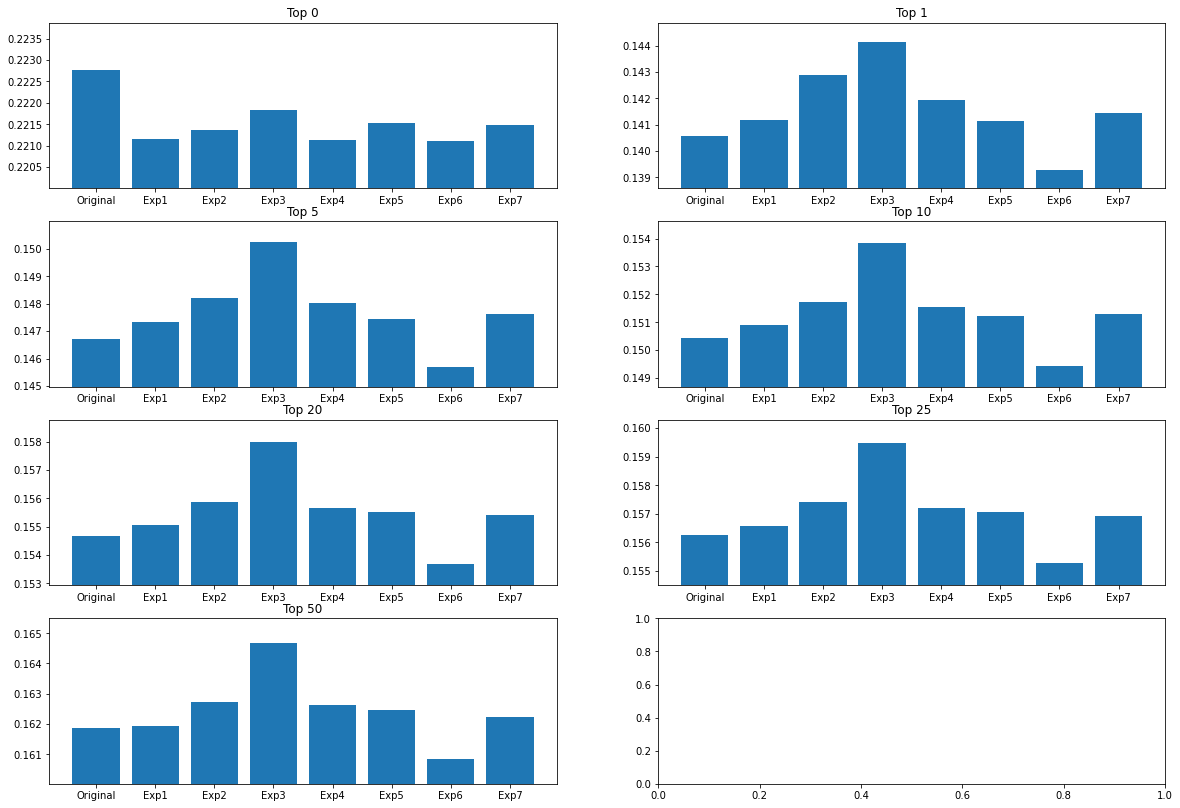

In [152]:
ks = [0, 1,5,10,20,25,50]
fig, axes = plt.subplots(4,2, figsize=(20,14))
axes = axes.ravel()

for i, k in enumerate(ks):
    ax = axes[i]
    ax.set_title(f'Top {k}')
    ax.bar(labels, topk[k])
    ax.set(ylim=[min(topk[k])*0.995, max(topk[k])*1.005])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def add_value_labels(ax, spacing=40, f=4):
    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_y() + rect.get_height() / 2
        x_value =  rect.get_width()

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # Use Y value as label and format number with one decimal place
        label = "{:.{}f}".format(x_value, f)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(space, 0),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va='center')                      # Vertically align label differently for
                                        # positive and negative values.

# Bring some raw data.
ssim_distance = [0.16186952590942383, 0.16194483637809753, 0.16273929178714752, 0.16466209292411804, 0.16264213621616364, 0.16246312856674194, 0.16083340346813202, 0.16223514080047607]
anomaly_score = [6.451, 6.567, 6.833, 6.804, 6.565, 7.103, 6.980, 7.415]


# In my original code I create a series and run on that,
# so for consistency I create a series from the list.

labels = ['Unedited Model', 'Frame Example 1', 'Frame Example 2', 'Frame Example 3', 'Frame Example 4', 'Handle Example 1', 'Handle Example 2', 'Handle Example 3']

# Plot the figure.
fig, axes = plt.subplots(1, 2, figsize=(16,8))
fig.subplots_adjust(wspace=0.2)

ax = axes[0]
ax.invert_yaxis()
min_x = min(anomaly_score)*0.9
max_x = round(max(anomaly_score)*1.08, 3)
ax.set_xlim([min_x, max_x])
#ax.set_xticks([])
ax.barh(labels, anomaly_score, color='#f39c12')
ax.set_title('SPADE Score')
add_value_labels(ax, f=3)

ax = axes[1] 
ax.invert_yaxis()
ax.get_yaxis().set_ticks([])
min_x = round(min(ssim_distance)*0.995, 3)
max_x = round(max(ssim_distance)*1.008, 3)
ax.set_xlim([min_x, max_x])
#ax.set_xticks([])
ax.barh(labels, ssim_distance, color='#63306f')
ax.set_title('SSIM Distance')
add_value_labels(ax, f=4)



#ax.set_xticklabels(ssim_distance)




plt.rcParams.update({'font.size': 24})
plt.savefig('evaluation_plot.pdf', format='pdf', bbox_inches='tight')
# Call the function above. All the magic happens there.


In [93]:
topk = {}
topk[1] = [0.71884406, 0.7176156, 0.71425986, 0.7117079, 0.71609807, 0.71773016, 0.72143996, 0.7170828, ]
topk[5] =[0.7065883, 0.7053597, 0.7035948, 0.69951624, 0.7039894, 0.70510906, 0.708596, 0.7047387, ]

topk[10] =[0.69910896, 0.69818723, 0.69655865, 0.6922982, 0.6969196, 0.6975305, 0.7011463, 0.6974465, ]
topk[20] = [0.69067234, 0.6898956, 0.68824434, 0.6840395, 0.6886747, 0.68899083, 0.69261664, 0.689179, ]
topk[25] = [0.68747604, 0.686831, 0.6851511, 0.6810233, 0.6855681, 0.68588394, 0.6894505, 0.68615603, ]
topk[50] = [0.67626095, 0.6761103, 0.67452145, 0.67067575, 0.6747157, 0.67507374, 0.6783333, 0.67552984, ]

In [90]:
labels = ['Original', 'Exp1', 'Exp2', 'Exp3', 'Exp4', 'Exp5', 'Exp6', 'Exp7']
anomaly_score = [6.451, 6.567, 6.833, 6.804, 6.565, 7.103, 6.980, 7.415]
total_novelty_score = [0.5528, 0.5577, 0.5573, 0.5563, 0.5577, 0.5577, 0.5578, 0.5570]
top50_novelty_score = [0.6664, 0.6761, 0.6745, 0.6707, 0.6747, 0.6751, 0.6783, 0.6755]
diversity_score = [-15.5191345, -15.070485, -15.081232, -15.100538, -15.077383, -15.1022625, -15.100836, -15.101259]

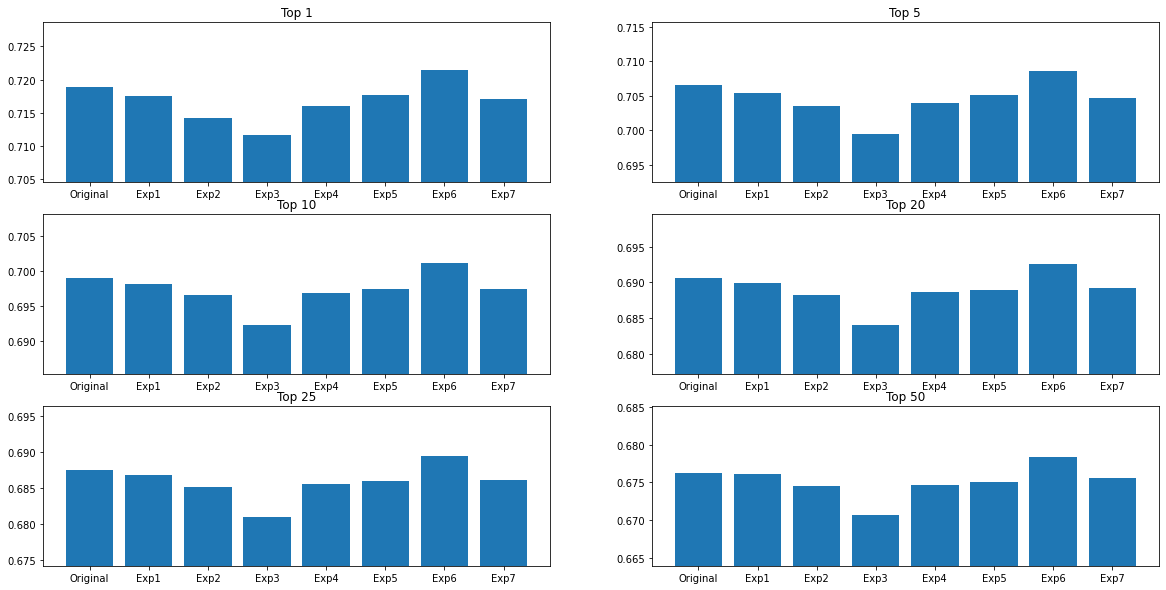

In [100]:
ks = [1,5,10,20,25,50]
fig, axes = plt.subplots(3,2, figsize=(20,10))
axes = axes.ravel()

for i, k in enumerate(ks):
    ax = axes[i]
    ax.set_title(f'Top {k}')
    ax.bar(labels, topk[k])
    ax.set(ylim=[min(topk[k])*0.99, max(topk[k])*1.01])

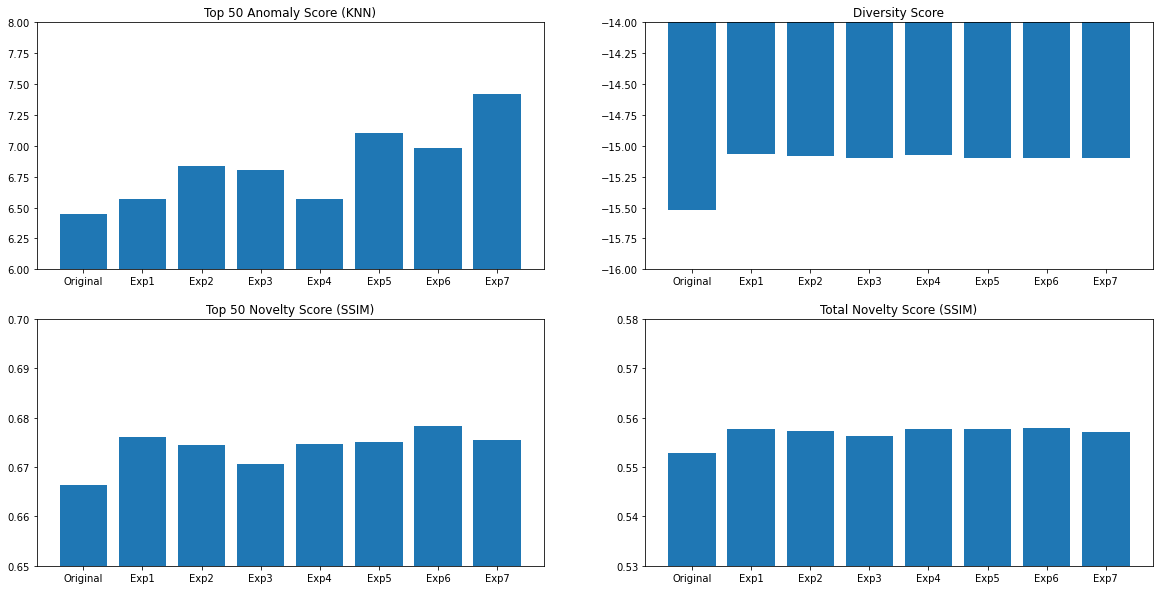

In [61]:
fig, axes = plt.subplots(2,2, figsize=(20,10))

ax = axes[0,0]
ax.set_title('top1')
ax.bar(labels, anomaly_score)
ax.set(ylim=[6,8])

ax = axes[0,1]
ax.set_title('Diversity Score')
ax.bar(labels, diversity_score)
ax.set(ylim=[-16,-14])

ax = axes[1,0]
ax.set_title('Top 50 Novelty Score (SSIM)')
ax.bar(labels, top50_novelty_score)
ax.set(ylim=[0.65,0.7])

ax = axes[1,1]
ax.set_title('Total Novelty Score (SSIM)')
ax.bar(labels, total_novelty_score)
ax.set(ylim=[0.53,0.58])

fig.savefig('bar_plot.jpg', bbox_inches='tight')


In [187]:
from torch.utils.data import DataLoader

# SSIM DIVERSITY

batch_size = 100
gen_dataset1 = anomaly.NormalDataset('genbike1k', grayscale=False, normalize=False, resize=512, cropsize=512)
gen_loader1 = DataLoader(gen_dataset1, batch_size=batch_size, pin_memory=True)
#n = len(gen_dataset1)
n = len(gen_dataset1)//batch_size
ssim_mat = torch.zeros((batch_size, batch_size))
ssim_dets = []
with tqdm(total= n*batch_size*batch_size) as pbar:
    for i, xb in enumerate(gen_loader1):
        for j, x in enumerate(xb):
            x = x.repeat(batch_size, 1, 1, 1)
            #print(y.reshape(-1).max())
            #ssim_mat[i][j*batch_size:j*batch_size+len(y)] = ssim( x.cuda(), y.cuda(), data_range=1, size_average=False)
            #print(i,j)
            ssim_mat[j] = ssim( x.cuda(), xb.cuda(), data_range=1, size_average=False)
            pbar.update(len(xb))
        ssim_mat = ssim_mat * (1 - torch.eye(batch_size,batch_size))
        ssim_det = np.linalg.det(ssim_mat)
        ssim_det = np.mean(np.log(np.maximum(np.linalg.eigh(ssim_mat)[0],1e-7)))
        ssim_dets.append(ssim_det)
print('Mean: ', np.mean(ssim_dets))
print('Std: ', np.std(ssim_dets))

100%|██████████| 100000/100000 [03:00<00:00, 553.51it/s]


Mean:  -15.5191345
Negative Log:  nan
Std:  0.063164026


/home/gridsan/ahnobari/.conda/envs/renv2/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log


In [66]:
n =  100
ssim_mat=np.zeros((n, n))
step = 100
with tqdm(total=n * n) as pbar:
    for i in range(n):
        img1 = gw.render_image(i)
        for s in range(0,n,step):
            images = gw.render_image_batch(list(range(step)))
            for j in range(s, s+step):
                if i != j:
                    ssim_mat[i][j] = compare_ssim(np.array(img1),np.array(images[j-s]),multichannel=True)
                pbar.update(1)
np.linalg.det(ssim_mat)            

  0%|          | 1/10000 [00:03<10:40:42,  3.84s/it]/home/gridsan/ahnobari/.conda/envs/renv2/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 10000/10000 [17:26<00:00,  9.56it/s] 


-2.3705814603701448e-21

ssim_mat

0.0

In [ ]:
import matplotlib.patches

y_offset = 0
x_offset = 1
n = 3
n_col = 3

mask_savedir = "rewriting_masks"
result_savedir = "rewriting_results"

row = n//n_col
col = n_col * 2

fig, axes = plt.subplots(y_offset + row, x_offset+col, figsize=((x_offset+col)*2.56, (y_offset+row)*2.56))
plt.rcParams.update({'font.size': 14})

#fig.suptitle("Context", y=0.91, x=0.51)
# adjust the subplots, i.e. leave more space at the top to accomodate the additional titles
# fig.subplots_adjust(top=0.1, bottom=0)     

for ax in axes.ravel():
    ax.axis('off')
    
req = interface.request

obj = render_mask(req['object'], gw)
paste = render_mask(req['paste'], gw)
axes[0].imshow(obj)
axes[0].set_title('Novel Feature', y=1.08)
# axes[0, 1].imshow(paste)
# axes[0, 5].set_title('Paste', y=1.08)
# axes[0, 5].imshow(paste)

# axes[1, 0].title.set_text('Context')
# for i in range(min(4, len(req['key']))):
#     context = render_mask(req['key'][i], gw)
#     axes[0, i+1].imshow(context)


for c in range(n_col):
    axes[x_offset+c*2].set_title('Unmodified', y=1.08)
    axes[x_offset+c*2+1].set_title('Changed', y=1.08)

for i in range(n):
    #idx = handpicks[i]
    idx = i 
    ax1 = axes[x_offset+i//row*2]
    ax2 = axes[x_offset+i//row*2 + 1]
    
    ax1.imshow(images[idx+6])
    ax2.imshow(edited_images[idx+6])
    
    ax1.set_zorder(1)
    ax2.set_zorder(0)
    
    patch = matplotlib.patches.ConnectionPatch(
        xyA=(512, 200),
        xyB=(0, 200),
        coordsA="data",
        coordsB="data",
        axesA=ax1,
        axesB=ax2,
        arrowstyle="->",
        mutation_scale=20,
        clip_on=False,
    )
    ax1.add_artist(patch)

fig.savefig('rewriting_frame_example4_format1', bbox_inches='tight')

In [41]:
train_embeddings = ad.train_outputs['avgpool'].squeeze().detach().cpu()
original_scores = ad.predict_anomaly_scores(images)
original_embeddings = ad.test_outputs['avgpool'].squeeze().detach().cpu()
edited_scores = ad.predict_anomaly_scores(edited_images)
edited_embeddings = ad.test_outputs['avgpool'].squeeze().detach().cpu()
copy_score = ad.predict_anomaly_scores([gw.render_image(copy_id)])
copy_embedding = ad.test_outputs['avgpool'].squeeze(axis=3).squeeze(axis=2).detach().cpu()
print(copy_embedding)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_embeddings)
train = pca.transform(train_embeddings)
original = pca.transform(original_embeddings)
edited = pca.transform(edited_embeddings)
copy_feature = pca.transform(copy_embedding)

| feature extraction |: 100%|██████████| 7/7 [00:01<00:00,  5.46it/s]
| feature extraction |: 100%|██████████| 7/7 [00:01<00:00,  6.50it/s]
| feature extraction |: 100%|██████████| 1/1 [00:00<00:00, 90.83it/s]


tensor([[0.9283, 0.3318, 0.0848,  ..., 0.3989, 0.1194, 0.0973]])


In [42]:
import numpy as np
from tqdm import tqdm

anomaly_scores = []
generated_embeddings = []
for i in range(0, 1000, 100):
    images = gw.render_image_batch(list(range(i,i+100)))
    scores = ad.predict_anomaly_scores(images, topk=50)
    anomaly_scores.append(scores)
    embs = ad.test_outputs['avgpool'].squeeze().detach().cpu()
    embs_2d = pca.transform(embs)
    generated_embeddings.append(embs_2d)
    
anomaly_scores = np.concatenate(anomaly_scores)
generated_embeddings = np.concatenate(generated_embeddings)
print(anomaly_scores.shape)
print(generated_embeddings.shape)

| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  6.96it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  7.30it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  7.38it/s]


(1000,)
(1000, 2)


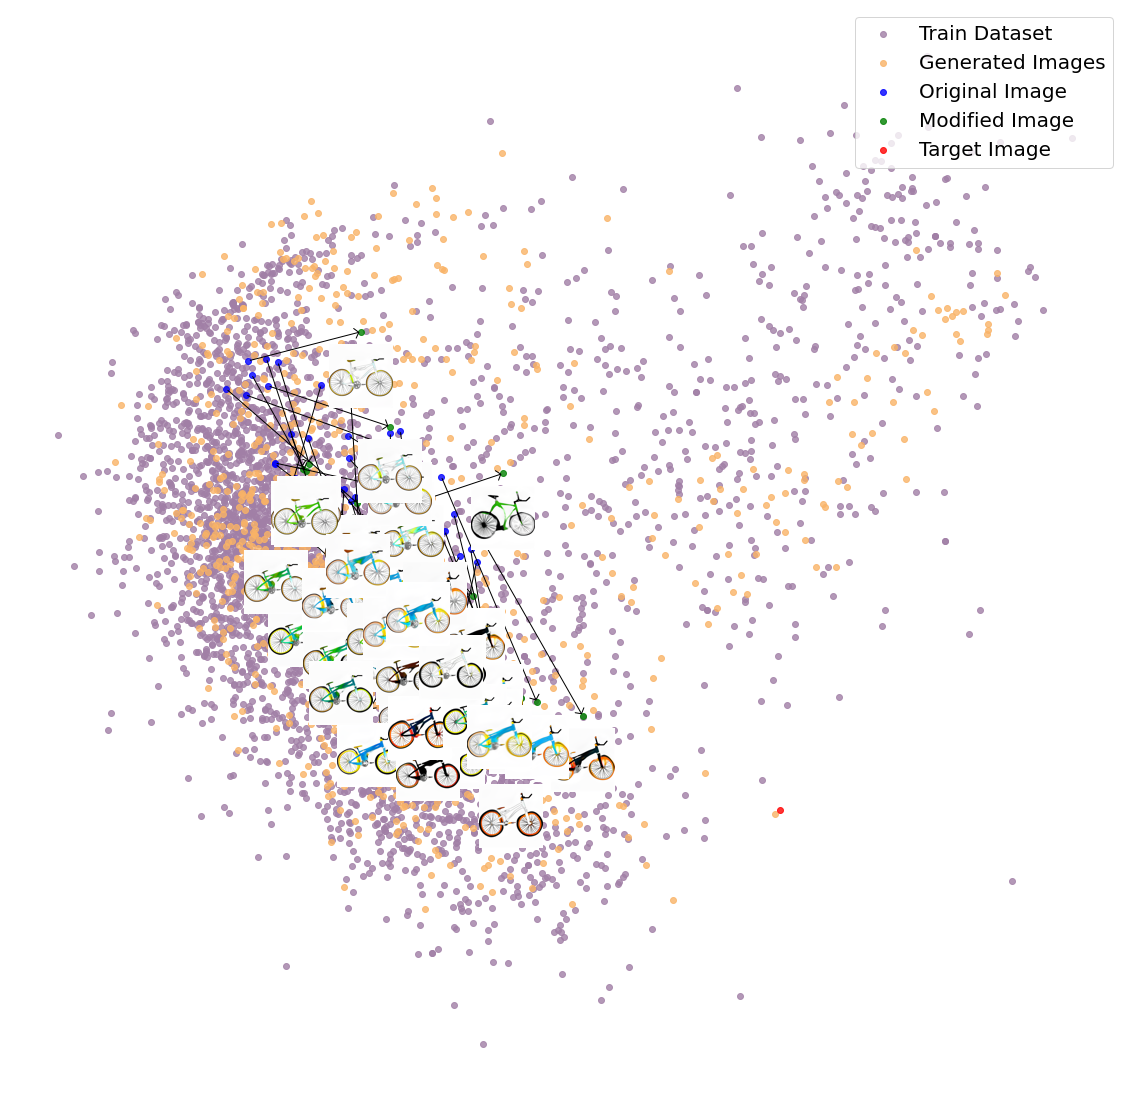

In [74]:
import matplotlib.pyplot as plt

# Number of blue point to show
n = 50
show_arrow = 1


y = []
labels = [
        'Train Dataset',
         'Generated Images',
          'Original Image', 'Modified Image', 'Target Image']
cdict = [
        '#a17fa6',
         '#f9b367',
        'blue', 'green', 'red']
arrs = [
        train,
        generated_embeddings,
        original[:n], edited[:n], copy_feature]
for i, arr in enumerate(arrs):
    plt.scatter(arr[:, 0], arr[:, 1], c=cdict[i], label=labels[i], alpha=0.8)

if show_arrow:
    for  i in range(len(original[:n])):
        plt.annotate("", xy=edited[i], xytext=original[i], arrowprops=dict(arrowstyle="->, head_width=0.5"))

if True:
    for i in range(n):
        x, y = edited[i]
        imscatter(x, y-1, edited_images[i].resize((64,64)))

plt.axis('off')
plt.legend(fontsize=20, loc=1)
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.savefig(f'result_embeddings/embedding_layer{layer}_c{copy_id}_p{paste_id}_n{n}.svg', format='svg', bbox_inches='tight')
plt.show()


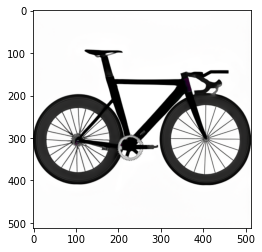

In [61]:
plt.imshow(images[0])

In [65]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
#     try:
#         image = plt.imread(image)
#     except TypeError:
#         # Likely already an array...
#         pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

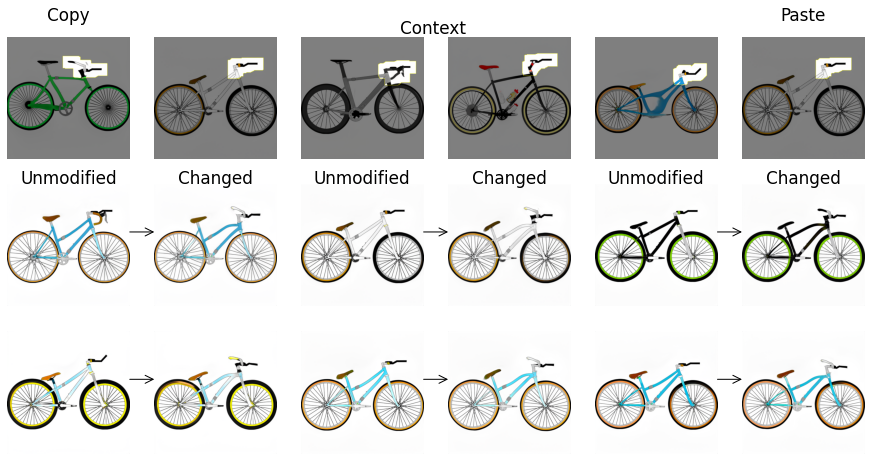

In [79]:
import matplotlib.patches

offset = 1
n = 6
n_col = 3

mask_savedir = "rewriting_masks"
result_savedir = "rewriting_results"

row = n//n_col
col = n_col * 2

fig, axes = plt.subplots(offset + row, col, figsize=(col*2.56, (offset+row)*2.56))
plt.rcParams.update({'font.size': 14})

fig.suptitle("Context", y=0.91, x=0.51)
# adjust the subplots, i.e. leave more space at the top to accomodate the additional titles
# fig.subplots_adjust(top=0.1, bottom=0)     

for ax in axes.ravel():
    ax.axis('off')
    


req = interface.request

obj = render_mask(req['object'], gw)
paste = render_mask(req['paste'], gw)
axes[0, 0].imshow(obj)
axes[0, 0].set_title('Copy', y=1.08)
# axes[0, 1].imshow(paste)
axes[0, 5].set_title('Paste', y=1.08)
axes[0, 5].imshow(paste)

axes[1, 0].title.set_text('Context')
for i in range(min(4, len(req['key']))):
    context = render_mask(req['key'][i], gw)
    axes[0, i+1].imshow(context)


for c in range(n_col):
    axes[offset, c*2].set_title('Unmodified', y=0.95)
    axes[offset, c*2+1].set_title('Changed', y=0.95)

for i in range(n):
    #idx = handpicks[i]
    idx = i
    ax1 = axes[offset+i%row, i//row*2]
    ax2 = axes[offset+i%row, i//row*2 + 1]
    
    ax1.imshow(images[idx])
    ax2.imshow(edited_images[idx])
    
    ax1.set_zorder(1)
    ax2.set_zorder(0)
    
    patch = matplotlib.patches.ConnectionPatch(
        xyA=(512, 200),
        xyB=(0, 200),
        coordsA="data",
        coordsB="data",
        axesA=ax1,
        axesB=ax2,
        arrowstyle="->",
        mutation_scale=20,
        clip_on=False,
    )
    ax1.add_artist(patch)

# fig.savefig('rewriting_handle_example3', bbox_inches='tight')

In [ ]:
# Figures for Top Novel Bikes

In [19]:
import numpy as np
from tqdm import tqdm

anomaly_scores = []
for i in range(0, 1000, 100):
    images = gw.render_image_batch(list(range(i,i+100)))
    scores = ad.predict_anomaly_scores(images, topk=1000)
    anomaly_scores.append(scores)

anomaly_scores = np.concatenate(anomaly_scores)
top_idx = anomaly_scores.argsort()[::-1]

| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  5.84it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  5.84it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  7.32it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  7.32it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00,  7.32it/s]


In [ ]:
import matplotlib.pyplot as plt

row = 12
col = 5

fig, axes = plt.subplots(row, col, figsize=(col*4,row*3))

for i in range(row*col):
    image = gw.render_image(top_idx[i])
    ax = axes[i//col, i%col]
    ax.imshow(image)
    ax.title.set_text(top_idx[i])
    # ax.text(top_idx[i])
    ax.axis('off')

fig.tight_layout(pad=0)
fig.savefig(f'bike_novel_top{row*col}.jpg', bbox_inches='tight')
fig.show()

In [17]:
# FIGURES FOR TOP NOVEL DATASET

import numpy as np
from tqdm import tqdm
from PIL import Image

train_dataset = anomaly.NormalDataset(data_path, grayscale=False, normalize=False)
image_files = train_dataset.x

anomaly_scores = []
for i in range(0, 1000, 100):
    images = []
    for x in range(i, i+100):
        images.append(Image.open(image_files[x]).resize((256,256)))
    scores = ad.predict_anomaly_scores(images, topk=50)
    anomaly_scores.append(scores)

anomaly_scores = np.concatenate(anomaly_scores)

top_idx = anomaly_scores.argsort()[::-1]

| feature extraction |: 100%|██████████| 4/4 [00:00<00:00, 11.36it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00, 11.04it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00, 12.22it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00, 10.96it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00, 10.44it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00, 11.03it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00, 10.91it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00, 12.11it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00, 10.99it/s]
| feature extraction |: 100%|██████████| 4/4 [00:00<00:00, 10.81it/s]


/home/gridsan/ahnobari/.conda/envs/renv2/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


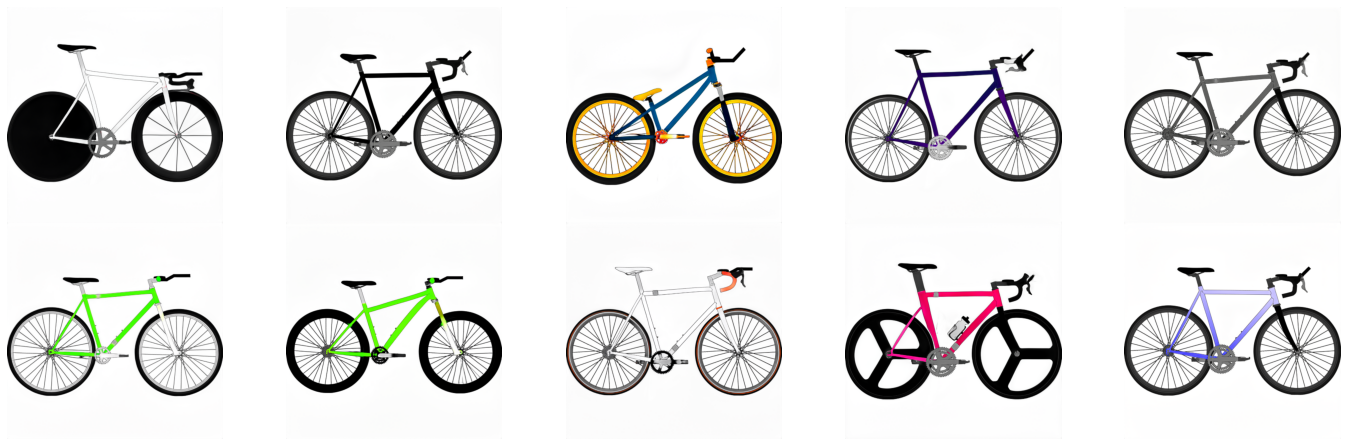

In [18]:
import matplotlib.pyplot as plt

row = 2
col = 5

fig, axes = plt.subplots(row, col, figsize=(col*4,row*3))

for i in range(row*col):
    image = gw.render_image(top_idx[i])
    ax = axes[i//col, i%col]
    ax.imshow(image)
    #ax.title.set_text(top_idx[i])
    # ax.text(top_idx[i])
    ax.axis('off')

fig.tight_layout(pad=0)
fig.savefig(f'bike_dataset_novel_top{row*col}.jpg', bbox_inches='tight')
fig.show()